# Intro
This notebook represents the next step of the project - evaluation of PSF estimation

In [1]:
import sys
import os

import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt

import torch
from PIL import Image
from IPython.display import clear_output
import time
from enum import Enum

os.getcwd()

'/home/roman_kiryanov'

In [16]:
import tifffile as tiff

In [17]:
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio

In [3]:
from microscopy_data_classes import microscope_info, z1, ls, stack3D

## Initialization of microscopy data classes

In [3]:
z1_ex = z1()
ls_ex = ls()

### Example: Dataset 2 custom light sheet microscopy data

random example: section0345.tif
Num of slices: 402 , slice shape: (802, 1040) , initial dtype: uint8
Slice memory: 814.53 kilobytes; Brain memory: 319.77 megabytes


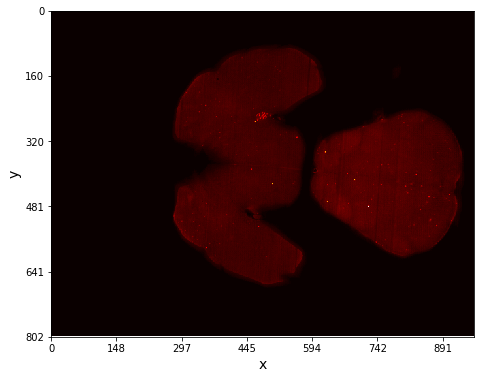

In [5]:
b = stack3D(ls_ex)

x: (740, 990) y: (366, 616) z: (206, 211)


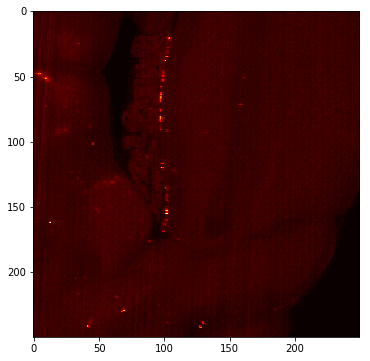

In [6]:
img= b.get_sample()

plt.figure(figsize=(8,6))
plt.imshow(img[:,:,0], cmap='hot')
plt.show()

x: (600, 650) y: (630, 700) z: (140, 160)


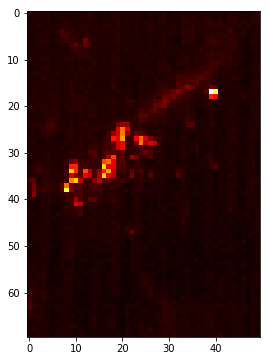

In [7]:
img= b.get_sample(  ((600, 650),(630, 700), (140, 160)) )
#img= b.get_sample(  ((450, 700),(550, 700), (140, 160)) )

plt.figure(figsize=(8,6))
plt.imshow(img[:,:,img.shape[2]//2], cmap='hot')
plt.show()

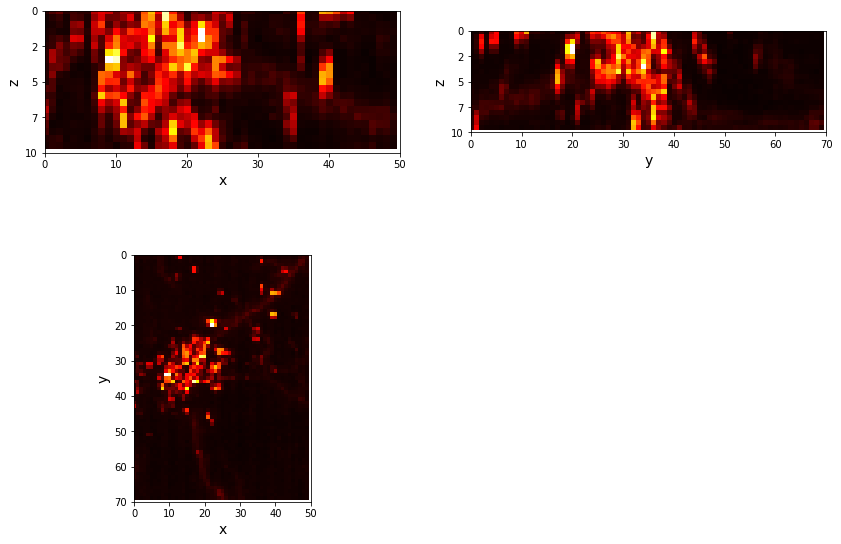

In [8]:
b.projections(img, transpose=True, resize=False)

### Example: Dataset 1. high-res commercial light-sheet data

In [62]:
b = stack3D(z1_ex )

random example: Sample3_4x5_561nm_PI-stitched frame 1 plane 397.tif
Num of slices: 572 , slice shape: (7680, 9600) , initial dtype: uint8
Slice memory: 70.31 megabytes; Brain memory: 39.28 gigabytes


In [10]:
img= b.get_sample(  ((600,800), (3450,3800), (60,80)) )
#img= b.get_sample(  ((0,1000), (3000,4000), (50,100)) )

x: (600, 800) y: (3450, 3800) z: (60, 80)


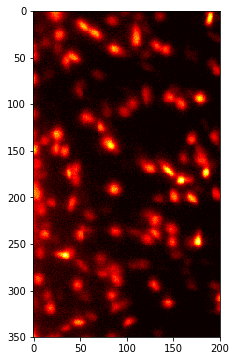

In [11]:
plt.figure(figsize=(8,6))
plt.imshow(img[:,:,img.shape[2]//2], cmap='hot')
plt.show()

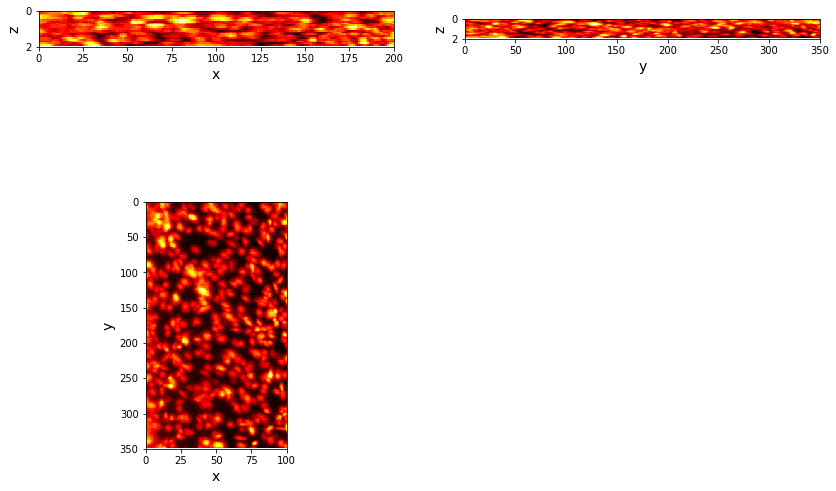

In [12]:
b.projections(img, transpose=True, resize=False)

<hr>

# eSRGAN and fineTuneSRGAN

In [18]:
# mmsr project RRDB_net is in mmsr repo
#sys.path.insert(0, '/home/roman_kiryanov/mmsr/codes/')
#sys.path.insert(0, '/home/roman_kiryanov/mmsr/codes/models/archs/')
#import RRDBNet_arch as arch

# only this function
import mmsr_code.RRDBNet_arch as arch

In [ ]:
#device = torch.device(1) # for GPU
device = 'cpu'

# Original esrgan
original_esrgan = arch.RRDBNet(3, 3, 64, 23, gc=32)
original_weights = torch.load('./weights/RRDB_ESRGAN_x4.pth')
original_esrgan.load_state_dict(original_weights, strict=True)
original_esrgan.eval()
original_esrgan = original_esrgan.to(device)

# model from 18.01.2020
fine_tune_esrgan = arch.RRDBNet(3, 3, 64, 23, gc=32)
fine_tune_weights = torch.load('./weights/FineTuned_18012020_G.pth')
fine_tune_esrgan.load_state_dict(fine_tune_weights, strict=True)
fine_tune_esrgan.eval()
fine_tune_esrgan = fine_tune_esrgan.to(device)

# Interpolated model
alpha = 0.5

interpolated_weiths = OrderedDict()
for k, fine_tuned_item in fine_tune_weights.items():
    original_item = original_weights[k]
    interpolated_weiths[k] = (1 - alpha) * fine_tuned_item + alpha * original_item
    
interp_esrgan = arch.RRDBNet(3, 3, 64, 23, gc=32)
interp_esrgan.load_state_dict(interpolated_weiths, strict=True)
interp_esrgan.eval()
interp_esrgan = interp_esrgan.to(device)

In [22]:
def predict(model, image):
    image = np.transpose([image,image,image], (1,2,0))
    
    image = torch.from_numpy(np.transpose(image[:, :, [2, 1, 0]], (2, 0, 1))).float()
    image = image/255
    image = image.unsqueeze(0)
    image = image.to(device)

    # Generate eSRGAN image
    with torch.no_grad():
        image_cpu = model(image)
    image_cpu = image_cpu.data.squeeze().float().cpu().clamp_(0, 1).numpy()
    del image
    image_cpu = np.transpose(image_cpu[[2, 1, 0], :, :], (1, 2, 0))
    image_cpu = np.clip(image_cpu*255, 0,255)
    image_cpu = image_cpu.astype(np.uint8)
    
    torch.cuda.empty_cache()
    return image_cpu[:,:,0]

### Z1

In [64]:
brain = stack3D(z1_ex)

random example: Sample3_4x5_561nm_PI-stitched frame 1 plane 278.tif
Num of slices: 572 , slice shape: (7680, 9600) , initial dtype: uint8
Slice memory: 70.31 megabytes; Brain memory: 39.28 gigabytes


x: (0, 8228) y: (0, 7680) z: (100, 101)


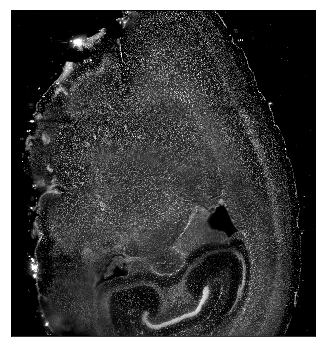

In [80]:
one_slice = brain.get_sample(  ((0, 8228), (0, 7680), (100, 101)) )


fig_tmp, ax_tmp = plt.subplots(ncols=1, nrows=1)
fig_tmp.set_figwidth(10)
fig_tmp.set_figheight(6)

to_show = np.flip(imutils.resize(one_slice, width=2000), axis=1).T
to_show = np.power(to_show, 0.7)

ax_tmp.imshow(to_show, cmap='gray')
ax_tmp.set_xticks(())
ax_tmp.set_yticks(())
plt.show()

In [82]:
name = 'one_slice'

fig_tmp.savefig(
    os.path.join('./real_data_distributions_psnr_ssim_03052020/', 'data_Z1_'+name+'.png'), 
    dpi=300, facecolor='w', edgecolor='w',
    orientation='portrait', papertype=None, format=None,
    transparent=True, bbox_inches='tight', pad_inches=0.0,
    frameon=None, metadata=None
)

### Collect values

In [28]:
import pickle

In [ ]:
collect = {
    'bic-psnr':[], 'bic-ssim':[],
    'or-psnr':[], 'or-ssim':[],
    'ft-psnr':[], 'ft-ssim':[],
    'in-psnr':[], 'in-ssim':[],
}
scale = 0.25

In [110]:
for j in range(20):
    x = np.random.randint(1000, 6000)
    y = np.random.randint(500, 5000)
    z = np.random.randint(10, 500)
    
    im_true = brain.get_sample(  ((x, x+300),(y, y+300), (z, z+1)) )[:,:,0]
    
    lr = cv2.resize(
        im_true, 
        (int(im_true.shape[1]*scale), int(im_true.shape[0]*scale)), 
        cv2.INTER_LINEAR
    )

    slice_bicubic = cv2.resize(
        lr, 
        (int(lr.shape[1]*4), 
         int(lr.shape[0]*4)), 
        cv2.INTER_CUBIC
    )

    esrgan_predicted = predict(original_esrgan, lr)
    ftsrgan_predicted = predict(fine_tune_esrgan, lr)
    interp_predicted = predict(interp_esrgan, lr)
    
    for im_test, model_name in zip(
        [slice_bicubic, esrgan_predicted, ftsrgan_predicted, interp_predicted],
        ['bic', 'or', 'ft', 'in']
    ):
        ssim_metrics = structural_similarity(
            im1 = im_true, 
            im2 = im_test
        )
        psnr_metrics = peak_signal_noise_ratio(
            image_true = im_true, 
            image_test = im_test
        )
        collect[model_name+'-psnr'].append(psnr_metrics)
        collect[model_name+'-ssim'].append(ssim_metrics)
    
    print(j+1, 'done')

x: (2286, 2586) y: (1507, 1807) z: (135, 136)
1 done
x: (3218, 3518) y: (4007, 4307) z: (269, 270)
2 done
x: (2797, 3097) y: (715, 1015) z: (169, 170)
3 done
x: (3657, 3957) y: (727, 1027) z: (213, 214)
4 done
x: (5712, 6012) y: (1993, 2293) z: (58, 59)
5 done
x: (1314, 1614) y: (2513, 2813) z: (341, 342)
6 done
x: (1833, 2133) y: (3722, 4022) z: (342, 343)
7 done
x: (1406, 1706) y: (3282, 3582) z: (292, 293)
8 done
x: (3823, 4123) y: (1714, 2014) z: (292, 293)
9 done
x: (5662, 5962) y: (1626, 1926) z: (41, 42)
10 done
x: (4018, 4318) y: (1099, 1399) z: (229, 230)
11 done
x: (3994, 4294) y: (4382, 4682) z: (369, 370)
12 done
x: (4828, 5128) y: (4169, 4469) z: (311, 312)
13 done
x: (1644, 1944) y: (4155, 4455) z: (51, 52)
14 done
x: (4235, 4535) y: (3086, 3386) z: (199, 200)
15 done
x: (3702, 4002) y: (3480, 3780) z: (353, 354)
16 done
x: (3729, 4029) y: (1836, 2136) z: (260, 261)
17 done
x: (2185, 2485) y: (2582, 2882) z: (411, 412)
18 done
x: (3545, 3845) y: (4650, 4950) z: (299, 300)

In [211]:
with open('./data/distributions_psnr_ssim_dataset_1.pkl', 'wb') as f: 
    pickle.dump(collect, f)

### Load values

In [29]:
with open('./data/distributions_psnr_ssim_dataset_1.pkl', 'rb') as f: 
    collect = pickle.load(f)

In [30]:
def filter_values(values, border=40):
    return [v for v in values if v <=border]

### Matplotlib distributions

In [31]:
plt.figure(figsize=(12,7))
plt.hist(filter_values(collect['bic-psnr'],38), alpha=0.3, label ='Bicubic interpolation')
plt.hist(filter_values(collect['or-psnr'],38), alpha=0.3, label ='Original eSRGAN')
plt.hist(filter_values(collect['ft-psnr'],38), alpha=0.3, label ='Fine-tuned eSRGAN')
plt.hist(filter_values(collect['in-psnr'],38), alpha=0.3, label ='Interpolated eSRGAN')
plt.title('PSNR scores distribution', fontsize=16)
plt.legend()
plt.xlabel('PSNR values', fontsize=13)
plt.ylabel('Number of slices', fontsize=13)
plt.show()

In [32]:
plt.figure(figsize=(12,7))
plt.hist(collect['bic-ssim'], alpha=0.3, label ='Bicubic interpolation')
plt.hist(collect['or-ssim'], alpha=0.3, label ='Original eSRGAN')
plt.hist(collect['ft-ssim'], alpha=0.3, label ='Fine-tuned eSRGAN')
plt.hist(collect['in-ssim'], alpha=0.3, label ='Interpolated eSRGAN')
plt.title('SSIM scores distribution', fontsize=16)
plt.legend()
plt.xlabel('SSIM values', fontsize=13)
plt.ylabel('Number of slices', fontsize=13)
plt.show()

### Seaborn distributions

In [33]:
#!pip install --upgrade seaborn

In [34]:
import seaborn as sns

#### SSIM

/home/roman_kiryanov/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


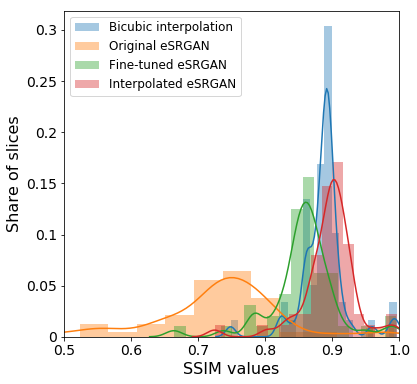

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(6)
fig.set_figwidth(6)

sns.distplot(collect['bic-ssim'], label ='Bicubic interpolation')
sns.distplot(collect['or-ssim'], label ='Original eSRGAN', norm_hist=True)
sns.distplot(collect['ft-ssim'], label ='Fine-tuned eSRGAN', norm_hist=True)
sns.distplot(collect['in-ssim'], label ='Interpolated eSRGAN', norm_hist=True)

plt.legend(fontsize=12)
#ax.set_title('SSIM scores distribution', fontsize=16)
ax.set_xlabel('SSIM values', fontsize=16)
ax.set_ylabel('Share of slices', fontsize=16)
ax.set_yticklabels([0,0.05,0.10,0.15,0.20,0.25,0.30])
ax.set_xlim(0.5, 1.0)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
plt.show()

In [57]:
score_type = 'ssim'
name = 'distplot_1'

fig.savefig(
    os.path.join('./real_data_distributions_psnr_ssim_03052020/', 'data_Z1_'+score_type+'_'+name+'.png'), 
    dpi=300, facecolor='w', edgecolor='w',
    orientation='portrait', papertype=None, format=None,
    transparent=True, bbox_inches='tight', pad_inches=0.0,
    frameon=None, metadata=None
)

#### PSNR

/home/roman_kiryanov/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


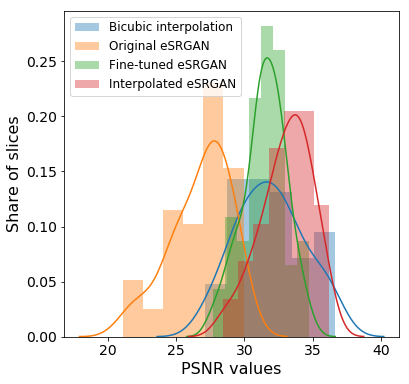

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(6)
fig.set_figwidth(6)

sns.distplot(filter_values(collect['bic-psnr'],38), label ='Bicubic interpolation', norm_hist=False)
sns.distplot(filter_values(collect['or-psnr'],38), label ='Original eSRGAN', norm_hist=False)
sns.distplot(filter_values(collect['ft-psnr'],38), label ='Fine-tuned eSRGAN', norm_hist=False)
sns.distplot(filter_values(collect['in-psnr'],38),  label ='Interpolated eSRGAN', norm_hist=False)

plt.legend(fontsize=12)
#ax.set_title('PSNR scores distribution', fontsize=16)
ax.set_xlabel('PSNR values', fontsize=16)
ax.set_ylabel('Share of slices', fontsize=16)
#ax.set_xlim(0.5, 1.0)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    
plt.show()

In [59]:
score_type = 'psnr'
name = 'distplot_1'

fig.savefig(
    os.path.join('./real_data_distributions_psnr_ssim_03052020/', 'data_Z1_'+score_type+'_'+name+'.png'), 
    dpi=300, facecolor='w', edgecolor='w',
    orientation='portrait', papertype=None, format=None,
    transparent=True, bbox_inches='tight', pad_inches=0.0,
    frameon=None, metadata=None
)

<br>

### Visualize generation

x: (1300, 1600) y: (4600, 4900) z: (100, 101)


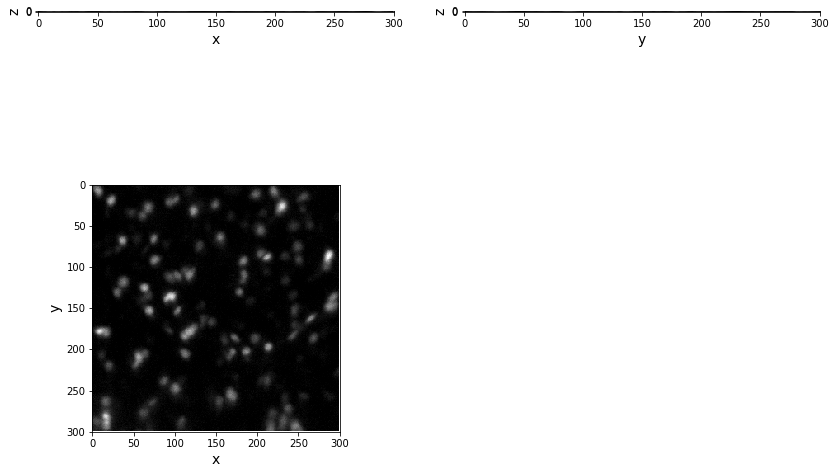

In [65]:
img= brain.get_sample(  ((1300, 1600),(4600, 4900), (100, 101)) )
brain.projections(img, transpose=True, resize=False)

In [43]:
#test_slice_initial = img[:,:,img.shape[2]//2]
#test_slice_initial = img[:,:,0]
test_slice_initial = img[:152,:152,0]

print(test_slice_initial.shape)
scale = 0.25
test_slice = cv2.resize(
    test_slice_initial, 
    (int(test_slice_initial.shape[1]*scale), int(test_slice_initial.shape[0]*scale)), 
    cv2.INTER_LINEAR
)
print(test_slice.shape)

slice_bicubic = cv2.resize(
    test_slice, 
    (int(test_slice.shape[1]*4), 
     int(test_slice.shape[0]*4)), 
    cv2.INTER_CUBIC
)

esrgan_predicted = predict(original_esrgan, test_slice)
psnr_predicted = predict(psnr_esrgan, test_slice)
ftsrgan_predicted = predict(fine_tune_esrgan, test_slice)
interp_predicted = predict(interp_esrgan, test_slice)

(152, 152)
(38, 38)


In [46]:
folder_to_save = './real_data_generated_comparison_02052020'

In [99]:
def add_scale_bar(image, length=10, ratio=1.26, scale=1.0):
    """
    length = 1 mkm - length of scalebar
    ratio = mkm / pix - num of mkm in one pixel
    scale = zoom 
    """
    image_inserted = image.copy()
    
    height = max(1, int(image.shape[0]//50))
    width = int( (length/ratio)/scale )
    if width <= 1:
        print('Not enough mkm to show scalebar')
    elif width > image.shape[1]: 
        print('Too much mkm to show scalebar')
    else:
        bar = np.ones((height, width))
        image_inserted[-3*height:-2*height, 3*height:(3*height+width)] = bar
    return image_inserted

/home/roman_kiryanov/anaconda3/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


BicubicResize: ssim = 0.9334307254485439, psnr = 37.40471281199447
OriginalESRGAN: ssim = 0.7569941820809334, psnr = 30.04892541777988
FineTunedSRGAN: ssim = 0.8979181720869045, psnr = 36.961455393378316
InterpolatedESRGAN: ssim = 0.9089033161079403, psnr = 38.17854724314421


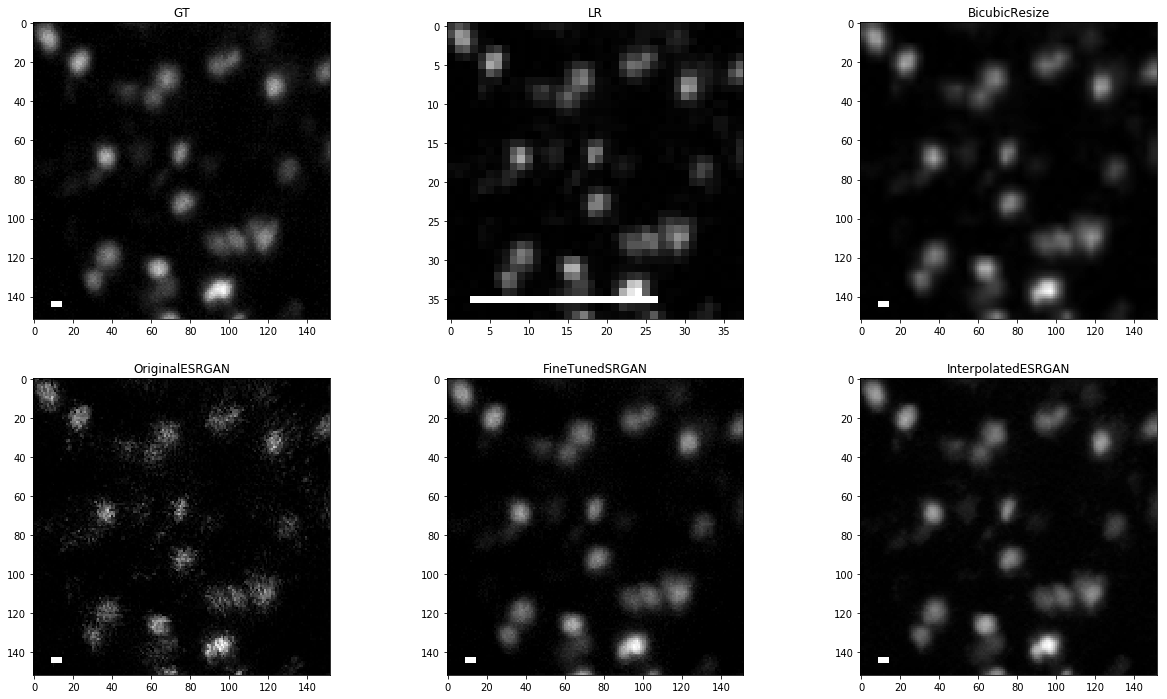

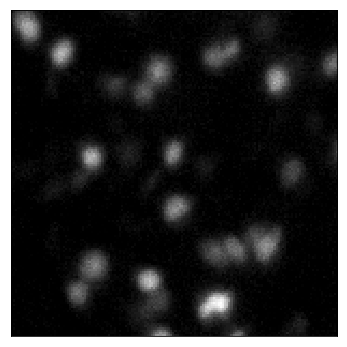

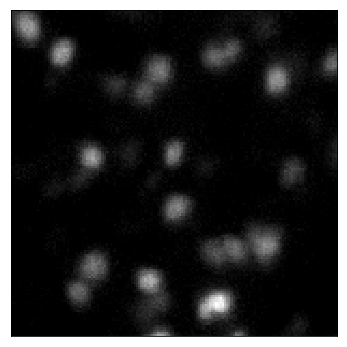

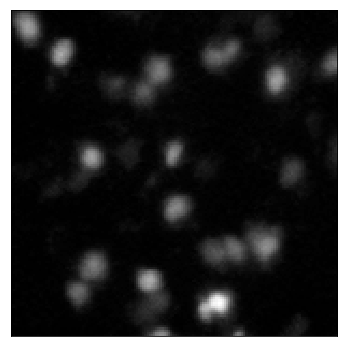

In [93]:
cmap = 'gray'
crop = '2'

fig, axes = plt.subplots(ncols=3, nrows=2)
fig.set_figwidth(21)
fig.set_figheight(12)

for ax, name, image in zip(
    axes.ravel(), 
    ['GT', 'LR', 'BicubicResize', 'OriginalESRGAN', 'FineTunedSRGAN', 'InterpolatedESRGAN'],
    [test_slice_initial, test_slice, slice_bicubic, esrgan_predicted, ftsrgan_predicted, interp_predicted]
):
    if name != 'LR':
        ssim_metrics = structural_similarity(
            im1 = test_slice_initial, 
            im2 = image
        )
        psnr_metrics = peak_signal_noise_ratio(
            image_true = test_slice_initial, 
            image_test = image
        )
        to_show = image/np.max(image)
        to_show = add_scale_bar(to_show, length=5, ratio=0.83, scale=1.0)
    else:
        to_show = image/np.max(image)
        to_show = add_scale_bar(to_show, length=5, ratio=0.83, scale=0.25)
    
    ax.imshow(to_show, cmap=cmap)
    ax.set_title(name)
    
    fig_tmp, ax_tmp = plt.subplots(ncols=1, nrows=1)
    fig_tmp.set_figwidth(6)
    fig_tmp.set_figheight(6)
    
    ax_tmp.imshow(image, cmap=cmap)
    ax_tmp.set_xticks(())
    ax_tmp.set_yticks(())
    """
    fig_tmp.savefig(
        os.path.join(folder_to_save, 'crop_'+crop, 'data_Z1_'+'crop_'+crop+'_'+name+'.png'), 
        dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=0.0,
        frameon=None, metadata=None
    )"""
    
    if name not in ['GT', 'LR']:
        print(f'{name}: ssim = {ssim_metrics}, psnr = {psnr_metrics}')
        
    """
    to_save_image = image/np.max(image)
    tiff.imsave( 
        os.path.join(folder_to_save, 'crop_'+crop, 'data_Z1_'+'crop_'+crop+'_'+name+'.tif'), np.float32(to_save_image) 
    )
    cv2.imwrite(
        os.path.join(folder_to_save, 'crop_'+crop, 'data_Z1_'+'crop_'+crop+'_'+name+'.png'),
        to_save_image*255
    )"""

plt.show()

In [66]:
fig.savefig('./test.png', dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.0,
        frameon=None, metadata=None)

### Ultra ls

random example: section0288.tif
Num of slices: 402 , slice shape: (802, 1040) , initial dtype: uint8
Slice memory: 814.53 kilobytes; Brain memory: 319.77 megabytes


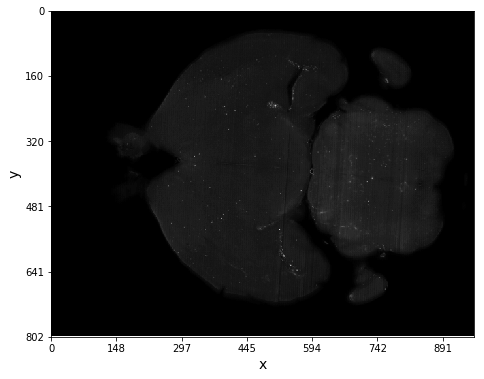

In [83]:
brain = stack3D(ls_ex)

x: (30, 1000) y: (0, 802) z: (200, 201)


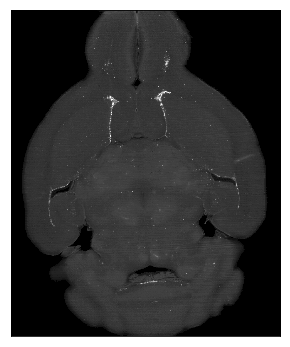

In [94]:
one_slice = brain.get_sample(  ((30, 1000), (0, 802), (200, 201)) )


fig_tmp, ax_tmp = plt.subplots(ncols=1, nrows=1)
fig_tmp.set_figwidth(10)
fig_tmp.set_figheight(6)

to_show = imutils.resize(one_slice, width=2000).T
to_show = np.power(to_show, 0.5)

ax_tmp.imshow(to_show, cmap='gray')
ax_tmp.set_xticks(())
ax_tmp.set_yticks(())
plt.show()

In [95]:
name = 'one_slice'

fig_tmp.savefig(
    os.path.join('./real_data_generated_comparison_02052020/','crop_LS', 'data_LS_'+name+'.png'), 
    dpi=300, facecolor='w', edgecolor='w',
    orientation='portrait', papertype=None, format=None,
    transparent=True, bbox_inches='tight', pad_inches=0.0,
    frameon=None, metadata=None
)

x: (500, 600) y: (550, 650) z: (100, 250)


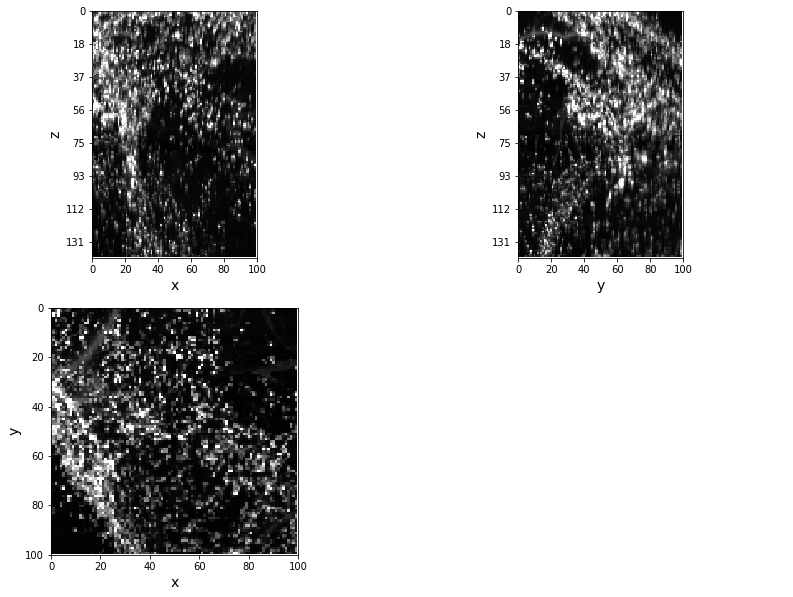

In [96]:
img= brain.get_sample(  ((500, 600),(550, 650), (100, 250)) )
brain.projections(img, transpose=True, resize=False)

In [160]:
folder_to_save = './real_data_generated_comparison_02052020'

In [149]:
z_idx = np.random.randint(0, img.shape[2])
z_idx

28

In [178]:
test_slice_initial = img[:,:,z_idx+3]
plt.imshow(test_slice_initial)

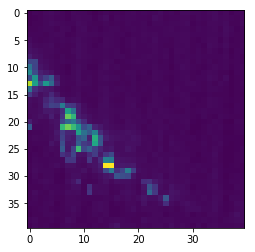

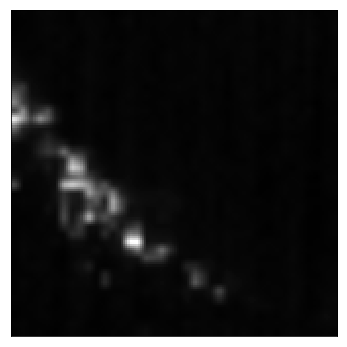

In [179]:
test_slice_initial = test_slice_initial[40:80,:40]
plt.imshow(test_slice_initial)
plt.show()

crop = '3'

slice_bicubic = cv2.resize(
    test_slice_initial, 
    (int(test_slice_initial.shape[1]*4), 
     int(test_slice_initial.shape[0]*4)), 
    cv2.INTER_CUBIC
)

fig_tmp, ax_tmp = plt.subplots(ncols=1, nrows=1)
fig_tmp.set_figwidth(6)
fig_tmp.set_figheight(6)

ax_tmp.imshow(slice_bicubic, cmap=cmap)
ax_tmp.set_xticks(())
ax_tmp.set_yticks(())

fig_tmp.savefig(
    os.path.join(folder_to_save, 'crop_LS_bicubic', 'data_LS_bicubic_'+'crop_'+crop+'.png'), 
    dpi=300, facecolor='w', edgecolor='w',
    orientation='portrait', papertype=None, format=None,
    transparent=True, bbox_inches='tight', pad_inches=0.0,
    frameon=None, metadata=None
)

In [159]:
slice_bicubic = cv2.resize(
    test_slice_initial, 
    (int(test_slice_initial.shape[1]*4), 
     int(test_slice_initial.shape[0]*4)), 
    cv2.INTER_CUBIC
)

esrgan_predicted = predict(esrgan, test_slice_initial)
psnr_predicted = predict(psnr_esrgan, test_slice_initial)
ftsrgan_predicted = predict(fine_tune_esrgan, test_slice_initial)
interp_predicted = predict(interp_esrgan, test_slice_initial)

GT


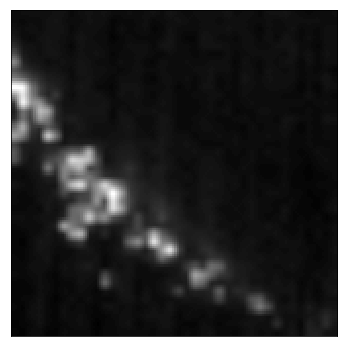

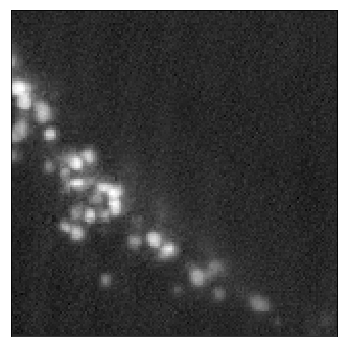

In [161]:
cmap = 'gray'
crop = '2'

fig, axes = plt.subplots(ncols=3, nrows=2)
fig.set_figwidth(21)
fig.set_figheight(12)

for ax, name, image in zip(
    axes.ravel(), 
    ['GT', 'LR', 'BicubicResize', 'OriginalESRGAN', 'FineTunedSRGAN', 'InterpolatedESRGAN'],
    [None, test_slice_initial, slice_bicubic, esrgan_predicted, ftsrgan_predicted, interp_predicted]
):
    
    #to_show = add_scale_bar(to_show, length=5, ratio=0.83, scale=0.25)
    if image is not None:
        to_show = image/np.max(image)
        to_show = np.power(to_show, 0.5)
        ax.imshow(to_show, cmap=cmap)
        
        fig_tmp, ax_tmp = plt.subplots(ncols=1, nrows=1)
        fig_tmp.set_figwidth(6)
        fig_tmp.set_figheight(6)

        ax_tmp.imshow(to_show, cmap=cmap)
        ax_tmp.set_xticks(())
        ax_tmp.set_yticks(())
        
        fig_tmp.savefig(
            os.path.join(folder_to_save, 'crop_LS_2', 'data_LS_'+'crop_'+crop+'_'+name+'.png'), 
            dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=True, bbox_inches='tight', pad_inches=0.0,
            frameon=None, metadata=None
        )
    else:
        print(name)
    ax.set_title(name)
    
        
    
        
    """
    to_save_image = image/np.max(image)
    tiff.imsave( 
        os.path.join(folder_to_save, 'crop_'+crop, 'data_Z1_'+'crop_'+crop+'_'+name+'.tif'), np.float32(to_save_image) 
    )
    cv2.imwrite(
        os.path.join(folder_to_save, 'crop_'+crop, 'data_Z1_'+'crop_'+crop+'_'+name+'.png'),
        to_save_image*255
    )"""

plt.show()

### X-Y projection

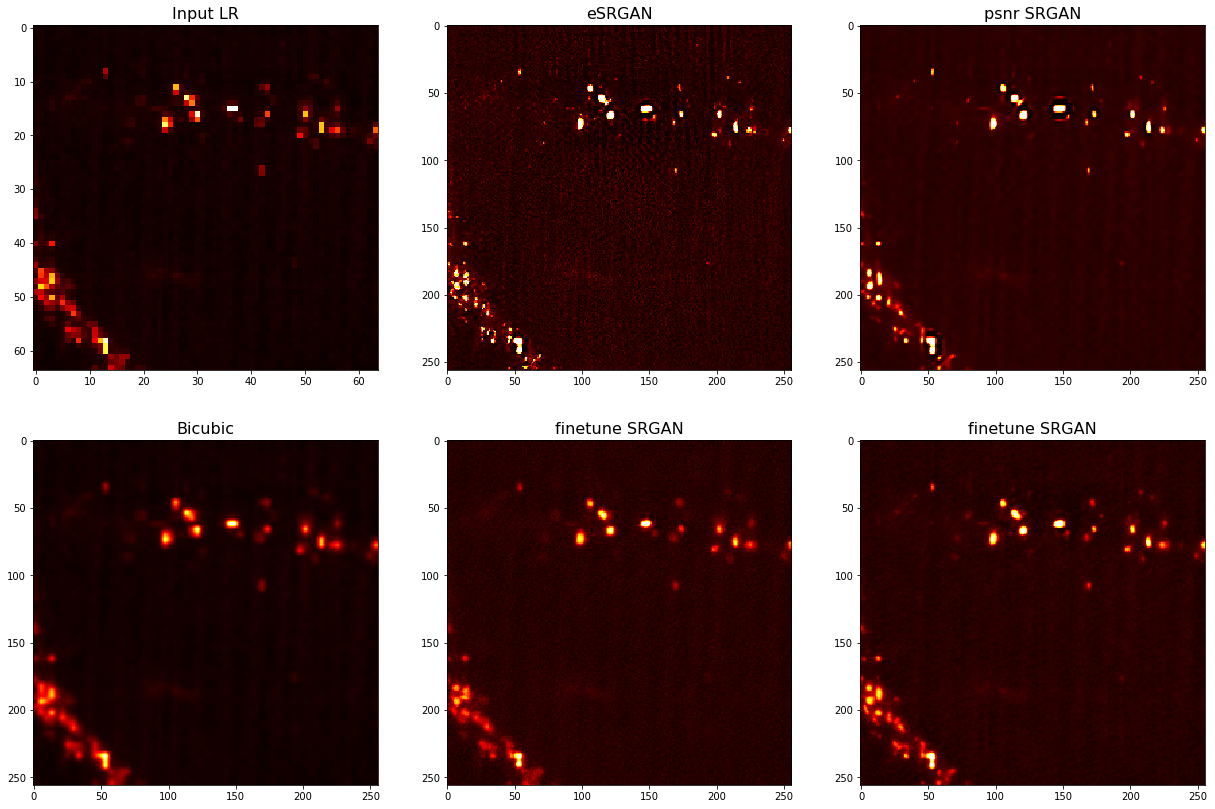

In [165]:
test_slice_initial = img[:,:,np.random.randint(0, img.shape[2])]

x = np.random.randint(0, test_slice_initial.shape[0]-64)
y = np.random.randint(0, test_slice_initial.shape[1]-64)

test_slice = test_slice_initial[x:x+64, y:y+64]
slice_bicubic = cv2.resize(test_slice, (int(test_slice.shape[1]*4), int(test_slice.shape[0]*4)), cv2.INTER_CUBIC)
slice_linear = cv2.resize(test_slice, (int(test_slice.shape[1]*4), int(test_slice.shape[0]*4)), cv2.INTER_LINEAR)

esrgan_predicted = predict(esrgan, test_slice)
psnr_predicted = predict(psnr_esrgan, test_slice)
ftsrgan_predicted = predict(fine_tune_esrgan, test_slice)
interp_predicted = predict(interp_esrgan, test_slice)
#interp_predicted = predict(fine_tune_esrgan_2, test_slice)


plt.figure(figsize=(21,14))
plt.subplot(231)
plt.imshow(test_slice, cmap='hot')
plt.title('Input LR',fontsize=16)
plt.subplot(232)
plt.imshow(esrgan_predicted, cmap='hot')
plt.title('eSRGAN',fontsize=16)
plt.subplot(233)
plt.imshow(psnr_predicted, cmap='hot')
plt.title('psnr SRGAN',fontsize=16)
plt.subplot(234)
plt.imshow(slice_bicubic, cmap='hot')
plt.title('Bicubic',fontsize=16)
plt.subplot(235)
plt.imshow(ftsrgan_predicted, cmap='hot')
plt.title('finetune SRGAN',fontsize=16)
plt.subplot(236)
plt.imshow(interp_predicted, cmap='hot')
plt.title('finetune SRGAN',fontsize=16)
plt.show()

### Deconvolution

In [12]:
from skimage import restoration

In [13]:
import skimage
skimage.__version__

'0.16.2'

In [14]:
def extract_psf(image, kernel, normalize = False):
    assert (image.shape[0] >= kernel.shape[0]) and (image.shape[1] >= kernel.shape[1]), 'Kernel is less than image'
    drop_channel = False
    if image.ndim ==2:
        image = np.expand_dims(image, 2)
        kernel = np.expand_dims(kernel, 2)
        drop_channel = True
    psf = np.zeros_like(image).astype(np.float32)
    
    for z in range(image.shape[2]):
        blurred_2d_image = image[:,:,z].astype(np.float32)/255
        kernel_2d_image = kernel[:,:,z].astype(np.float32)/255
        
        #print(kernel_2d_image.shape, kernel_2d_image.dtype, kernel_2d_image.max(), kernel_2d_image.min())
        
        dec_psf = restoration.unsupervised_wiener(blurred_2d_image, kernel_2d_image)[0]
        if normalize:
            dec_psf = dec_psf*(dec_psf>0)
            dec_psf = dec_psf/dec_psf.sum()
            #dec_psf = dec_psf/dec_psf.max()
        psf[:,:,z] = dec_psf
    
    if drop_channel:
        psf = np.squeeze(psf,2)
    return psf

In [240]:
%matplotlib inline 

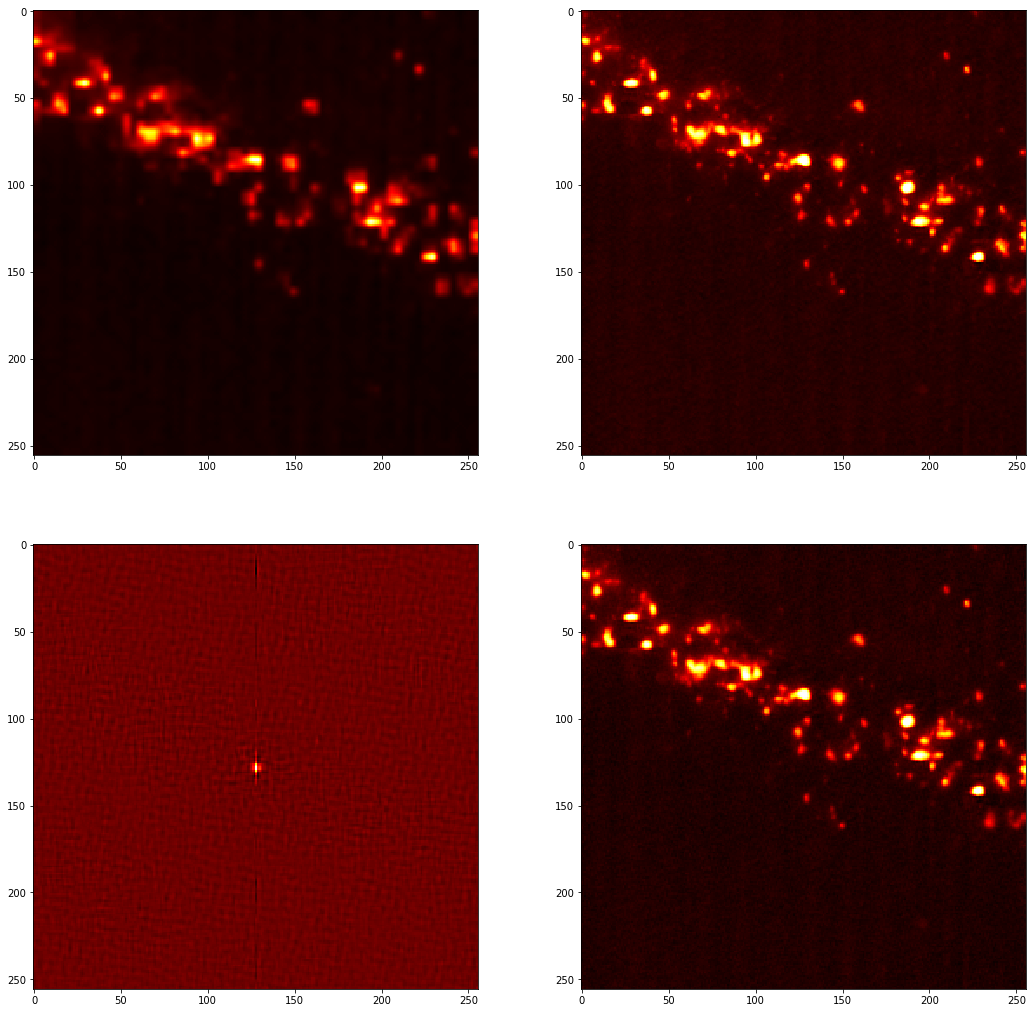

In [22]:
o, s = slice_bicubic, interp_predicted #psnr_predicted # #esrgan_predicted #

psf = extract_psf(o, s, normalize=False)
#crop_size = 50
#psf = psf[psf.shape[0]//2-crop_size:psf.shape[0]//2+crop_size, psf.shape[1]//2-crop_size:psf.shape[1]//2+crop_size]
dec = restoration.unsupervised_wiener(o, (psf*255).astype(np.float32))[0]

plt.figure(figsize=(18,18))
plt.subplot(221)
plt.imshow(o, cmap='hot')
plt.subplot(222)
plt.imshow(s, cmap='hot')
plt.subplot(223)
plt.imshow(psf, cmap='hot')
plt.subplot(224)
plt.imshow(dec, cmap='hot')
plt.show()

In [23]:
from mpl_toolkits.mplot3d import Axes3D

In [169]:
%matplotlib notebook

<IPython.core.display.Javascript object>


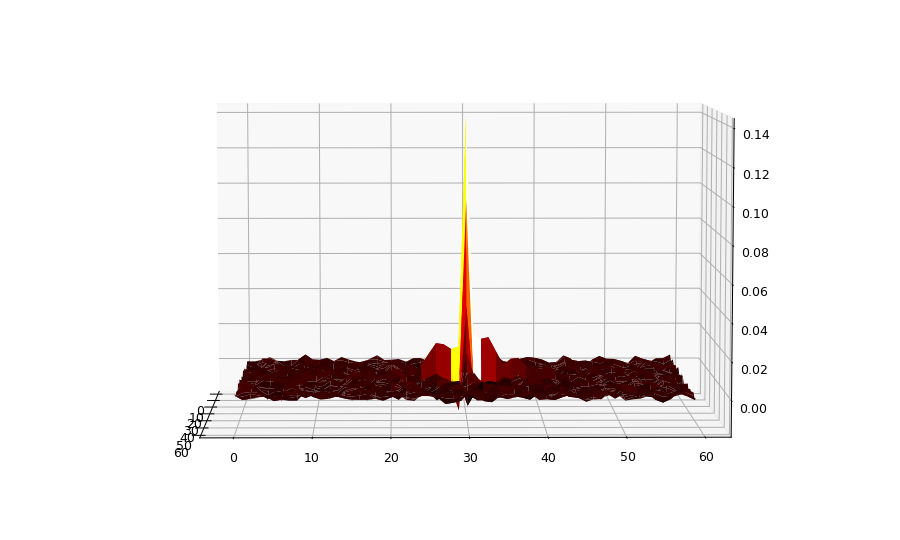

In [170]:
fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)

crop_size = 30
to_plot = psf[psf.shape[0]//2-crop_size:psf.shape[0]//2+crop_size, psf.shape[1]//2-crop_size:psf.shape[1]//2+crop_size]

X, Y = np.meshgrid(np.arange(0, to_plot.shape[0], 1), np.arange(0, to_plot.shape[1], 1))
Z = to_plot
ax.plot_surface(X, Y, Z, cmap='hot')
plt.show()

### Y-Z Projection

In [26]:
%matplotlib inline

In [30]:
test_slice_initial = img[np.random.randint(0, img.shape[0]),:,:].T

x = np.random.randint(0, test_slice_initial.shape[0]-64)
y = np.random.randint(0, test_slice_initial.shape[1]-64)

test_slice = test_slice_initial[x:x+64, y:y+64]

slice_bicubic = cv2.resize(test_slice, (int(test_slice.shape[1]*4), int(test_slice.shape[0]*4)), cv2.INTER_CUBIC)

esrgan_predicted = predict(esrgan, test_slice)
psnr_predicted = predict(psnr_esrgan, test_slice)
ftsrgan_predicted = predict(fine_tune_esrgan, test_slice)
#interp_predicted = predict(interp_esrgan, test_slice)
interp_predicted = predict(fine_tune_esrgan_2, test_slice)

plt.figure(figsize=(21,14))
plt.subplot(231)
plt.imshow(test_slice, cmap='hot')
plt.title('Input')
plt.subplot(232)
plt.imshow(esrgan_predicted, cmap='hot')
plt.title('eSRGAN')
plt.subplot(233)
plt.imshow(psnr_predicted, cmap='hot')
plt.title('psnr SRGAN')
plt.subplot(234)
plt.imshow(slice_bicubic, cmap='hot')
plt.title('Bicubic')
plt.subplot(235)
plt.imshow(ftsrgan_predicted, cmap='hot')
plt.title('finetune SRGAN')
plt.subplot(236)
plt.imshow(interp_predicted, cmap='hot')
plt.title('interpolated SRGAN')
plt.show()

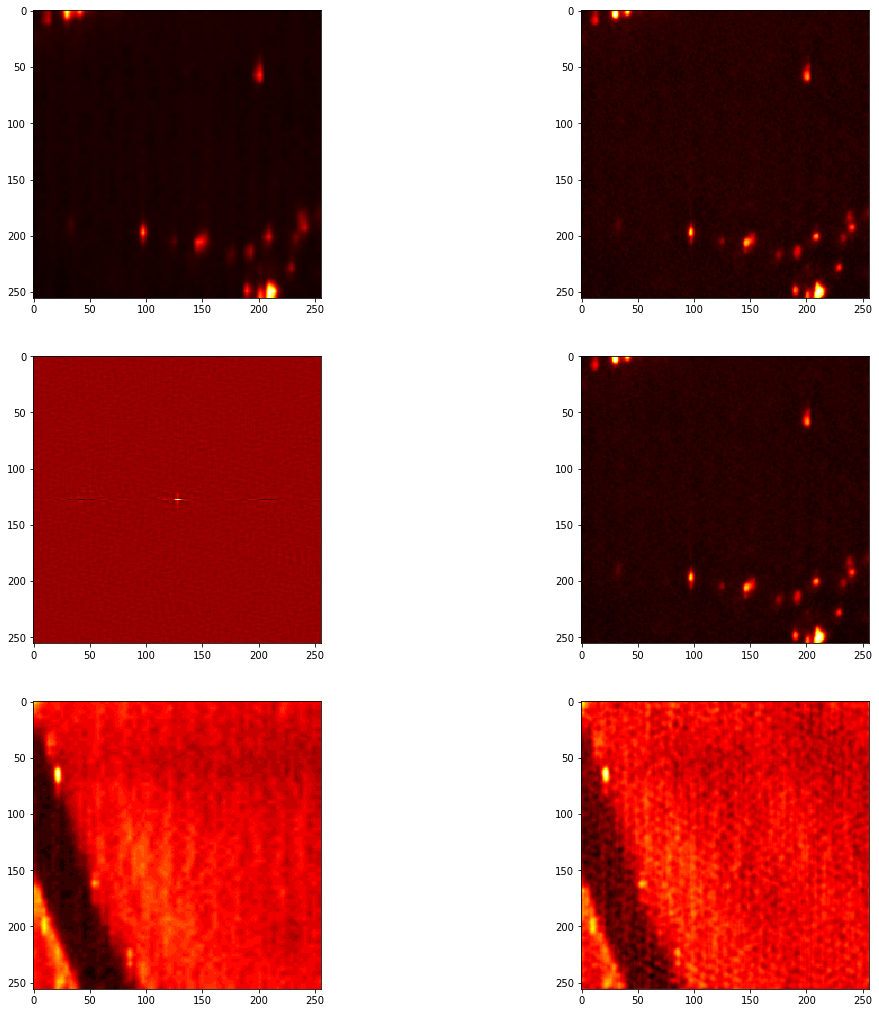

In [31]:
o, s = slice_bicubic, interp_predicted #interp_predicted #interp_predicted #psnr_predicted # #esrgan_predicted #

psf = extract_psf(o, s, normalize=False)
#crop_size = 50
#psf = psf[psf.shape[0]//2-crop_size:psf.shape[0]//2+crop_size, psf.shape[1]//2-crop_size:psf.shape[1]//2+crop_size]
dec = restoration.unsupervised_wiener(o, (psf*255).astype(np.float32))[0]

plt.figure(figsize=(18,18))
plt.subplot(321)
plt.imshow(o, cmap='hot')
plt.subplot(322)
plt.imshow(s, cmap='hot')
plt.subplot(323)
plt.imshow(psf, cmap='hot')
plt.subplot(324)
plt.imshow(dec, cmap='hot')


test_slice_initial = img[np.random.randint(0, img.shape[0]),:,:].T
x = np.random.randint(0, test_slice_initial.shape[0]-64)
y = np.random.randint(0, test_slice_initial.shape[1]-64)
test_slice = test_slice_initial[x:x+64, y:y+64]
slice_bicubic_2 = cv2.resize(test_slice, (int(test_slice.shape[1]*4), int(test_slice.shape[0]*4)), cv2.INTER_CUBIC)
dec_2 = restoration.unsupervised_wiener(slice_bicubic_2, (psf*255).astype(np.float32))[0]
plt.subplot(325)
plt.imshow(slice_bicubic_2, cmap='hot')
plt.subplot(326)
plt.imshow(dec_2, cmap='hot')

plt.show()

In [32]:
%matplotlib notebook

<IPython.core.display.Javascript object>


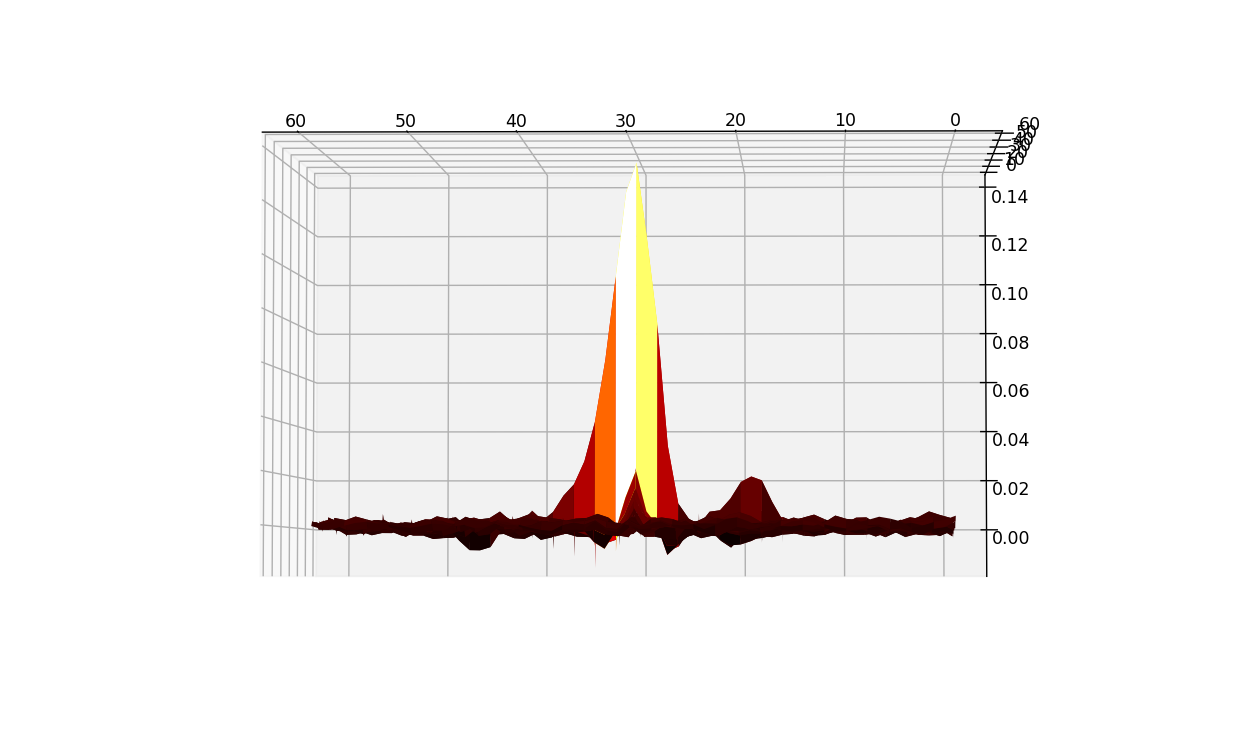

In [33]:
fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)

crop_size = 30
to_plot = psf[psf.shape[0]//2-crop_size:psf.shape[0]//2+crop_size, psf.shape[1]//2-crop_size:psf.shape[1]//2+crop_size]

X, Y = np.meshgrid(np.arange(0, to_plot.shape[0], 1), np.arange(0, to_plot.shape[1], 1))
Z = to_plot
ax.plot_surface(X, Y, Z, cmap='hot')
plt.show()

## 3D - PSF estimation attempts

In [34]:
%matplotlib inline

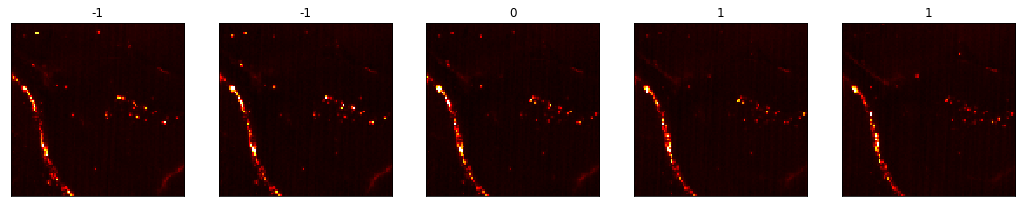

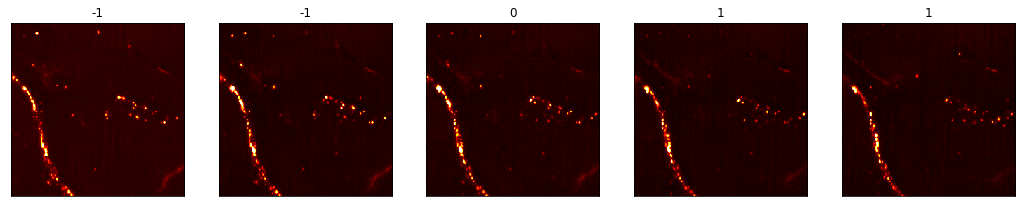

In [50]:
z = np.random.randint(2, img.shape[2]-2)

slice_zuu = img[:,:,z-2]
slice_zu = img[:,:,z-1]
slice_zc = img[:,:,z]
slice_zd = img[:,:,z+1]
slice_zdd = img[:,:,z+2]

plt.figure(figsize=(18,6))
plt.subplot(151, title='-1', xticks=(()), yticks=(()))
plt.imshow(slice_zuu, cmap='hot')
plt.subplot(152, title='-1', xticks=(()), yticks=(()))
plt.imshow(slice_zu, cmap='hot')
plt.subplot(153, title='0', xticks=(()), yticks=(()))
plt.imshow(slice_zc, cmap='hot')
plt.subplot(154, title='1', xticks=(()), yticks=(()))
plt.imshow(slice_zd, cmap='hot')
plt.subplot(155, title='1', xticks=(()), yticks=(()))
plt.imshow(slice_zdd, cmap='hot')
plt.show()

test_slice = slice_zc
slice_bicubic = cv2.resize(test_slice, (int(test_slice.shape[1]*4), int(test_slice.shape[0]*4)), cv2.INTER_CUBIC)

slice_zuu_1 = cv2.resize(slice_zuu, (int(test_slice.shape[1]*4), int(test_slice.shape[0]*4)), cv2.INTER_CUBIC)
slice_zu_1 = cv2.resize(slice_zu, (int(test_slice.shape[1]*4), int(test_slice.shape[0]*4)), cv2.INTER_CUBIC)
slice_zc_1 = cv2.resize(slice_zc, (int(test_slice.shape[1]*4), int(test_slice.shape[0]*4)), cv2.INTER_CUBIC)
slice_zd_1 = cv2.resize(slice_zd, (int(test_slice.shape[1]*4), int(test_slice.shape[0]*4)), cv2.INTER_CUBIC)
slice_zdd_1 = cv2.resize(slice_zdd, (int(test_slice.shape[1]*4), int(test_slice.shape[0]*4)), cv2.INTER_CUBIC)

slice_zuu = predict(interp_esrgan, slice_zuu)
slice_zu = predict(interp_esrgan, slice_zu)
slice_zc = predict(interp_esrgan, slice_zc)
slice_zd = predict(interp_esrgan, slice_zd)
slice_zdd = predict(interp_esrgan, slice_zdd)

plt.figure(figsize=(18,6))
plt.subplot(151, title='-1', xticks=(()), yticks=(()))
plt.imshow(slice_zuu, cmap='hot')
plt.subplot(152, title='-1', xticks=(()), yticks=(()))
plt.imshow(slice_zu, cmap='hot')
plt.subplot(153, title='0', xticks=(()), yticks=(()))
plt.imshow(slice_zc, cmap='hot')
plt.subplot(154, title='1', xticks=(()), yticks=(()))
plt.imshow(slice_zd, cmap='hot')
plt.subplot(155, title='1', xticks=(()), yticks=(()))
plt.imshow(slice_zdd, cmap='hot')
plt.show()

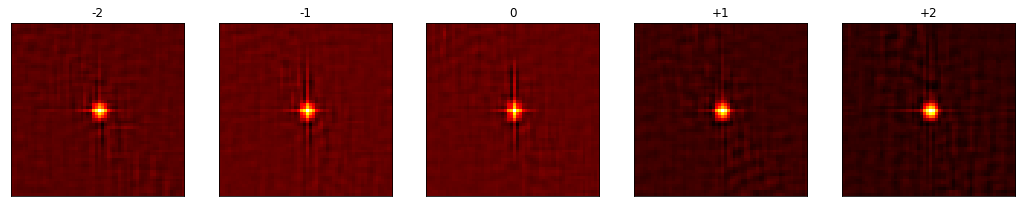

In [51]:
psf_c = extract_psf(slice_bicubic, slice_zc, normalize=False)

#psf_uu = extract_psf(slice_zuu, slice_zc, normalize=False)
#psf_u = extract_psf(slice_zu, slice_zc, normalize=False)
#psf_d = extract_psf(slice_zd, slice_zc, normalize=False)
#psf_dd = extract_psf(slice_zdd, slice_zc, normalize=False)

psf_uu = extract_psf(slice_zuu_1, slice_zuu, normalize=False)
psf_u = extract_psf(slice_zu_1, slice_zu, normalize=False)
psf_d = extract_psf(slice_zd_1, slice_zd, normalize=False)
psf_dd = extract_psf(slice_zdd_1, slice_zdd, normalize=False)


plt.figure(figsize=(18,6))
plt.subplot(151, title='-2', xticks=(()), yticks=(()))
plt.imshow(psf_uu[170:230, 170:230], cmap='hot')
plt.subplot(152, title='-1', xticks=(()), yticks=(()))
plt.imshow(psf_u[170:230, 170:230], cmap='hot')
plt.subplot(153, title='0', xticks=(()), yticks=(()))
plt.imshow(psf_c[170:230, 170:230], cmap='hot')
plt.subplot(154, title='+1', xticks=(()), yticks=(()))
plt.imshow(psf_d[170:230, 170:230], cmap='hot')
plt.subplot(155, title='+2', xticks=(()), yticks=(()))
plt.imshow(psf_dd[170:230, 170:230], cmap='hot')
plt.show()


In [195]:
combination = np.array([psf_uu, psf_u, psf_c, psf_d, psf_dd])
combination = np.transpose(combination,(1,2,0))
combination.shape

(400, 400, 5)

In [38]:
import tifffile as tiff

In [207]:
t = './test_crop_part_17012020/'

for i in range(5):
    test_psf_3 = combination[:,:,i]
    test_psf_3 = test_psf_3 + np.abs(np.min(test_psf_3))
    test_psf_3 = test_psf_3/np.max(test_psf_3)
    print(test_psf_3.max(), test_psf_3.min(), np.median(test_psf_3))
    tiff.imsave( os.path.join(t, 'psf_attempt_1', 'C0000Z'+'{:04d}'.format(i)+'.tif'), np.float32(test_psf_3) )

1.0 0.0 0.12809846
1.0 0.0 0.10228083
1.0 0.0 0.061061542
1.0 0.0 0.07393816
1.0 0.0 0.117098905


### Averaging

In [79]:
def restore(img, z, depth, gan):
    input_substack = np.zeros((img.shape[0], img.shape[1], 2*depth+1))
    if (z-depth) < 0:
        z += depth
    elif (z+depth) >= img.shape[2]:
        z = img.shape[2]- depth
    
    for z_idx, i in enumerate( range(-depth, depth+1) ):
        input_substack[:,:,z_idx] = img[:,:,z+i]
        #print(z+i)
    
    center = depth
    generated = np.zeros((img.shape[0]*4, img.shape[1]*4, 2*depth+1))
    bicubic = np.zeros((img.shape[0]*4, img.shape[1]*4, 2*depth+1))
    for i in range(input_substack.shape[2]):
        generated[:,:,i] = predict(gan, input_substack[:,:,i])
        bicubic[:,:,i] = cv2.resize(input_substack[:,:,i], (int(img.shape[1]*4), int(img.shape[0]*4)), cv2.INTER_CUBIC)
    
    print('Images generated')
    psf_v1 = np.zeros((img.shape[0]*4, img.shape[1]*4, 2*depth+1))
    psf_v2 = np.zeros((img.shape[0]*4, img.shape[1]*4, 2*depth+1))
    for i in range(input_substack.shape[2]):
        psf_v1[:,:,i] = extract_psf(bicubic[:,:,i], generated[:,:,i], normalize=False)
        
    print('psf_1 extracted')
    for i in np.arange(-depth, 0, 1):
        psf_v2[:,:,center+i] = extract_psf(bicubic[:,:,center+i], generated[:,:,center], normalize=False)
    
    psf_v2[:,:,center] = extract_psf(bicubic[:,:,center], generated[:,:,center], normalize=False)
    for i in np.arange(1, depth+1, 1):
        psf_v2[:,:,center+i] = extract_psf(bicubic[:,:,center+i], generated[:,:,center], normalize=False)
    print('psf_2 extracted')
    
    return psf_v1, psf_v2

x: (435, 535) y: (231, 331) z: (141, 191)


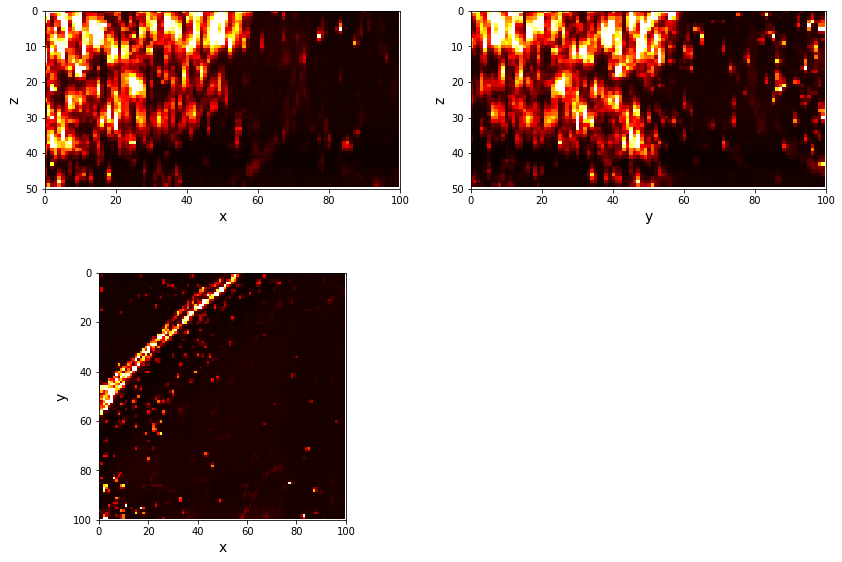

In [110]:
x_brain, y_brain, z_brain = np.random.randint(300,500), np.random.randint(150,550), np.random.randint(100,350)

img_2 = brain.get_sample(  ((x_brain, x_brain+100),(y_brain, y_brain+100), (z_brain, z_brain+50)) )

#img_2 = np.transpose(img_2, (1,2,0))

brain.projections(img_2 , transpose=True, resize=False)

In [122]:
depth = 4
psf_1, psf_2 = restore(img_2, 30, depth, interp_esrgan)

Images generated
psf_1 extracted
psf_2 extracted


In [ ]:
%matplotlib inline

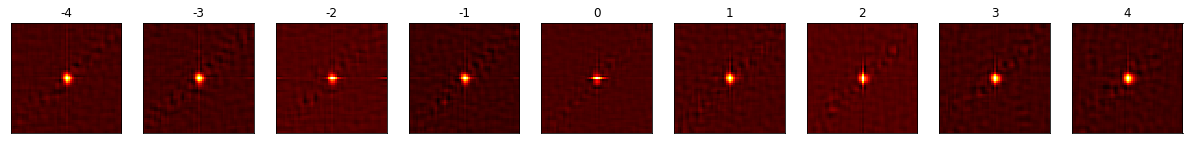

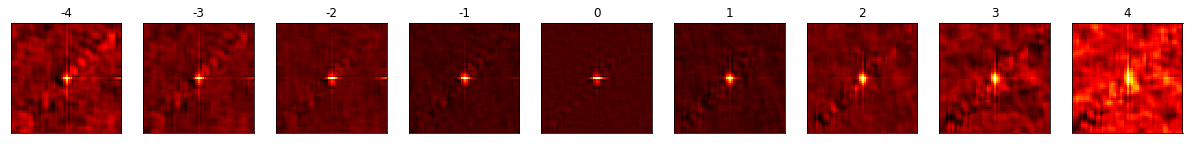

In [123]:
middle = psf_1.shape[0]//2
crop = 30

fig, axes = plt.subplots(nrows=1, ncols = psf_1.shape[2])
fig.set_figheight(8)
fig.set_figwidth(21)
for ax, psf_slice in zip(axes, range(psf_1.shape[2])):
    ax.imshow( psf_1[middle-crop:middle+crop, middle-crop:middle+crop, psf_slice], cmap='hot' )
    #ax.imshow( psf_1[:,:, psf_slice], cmap='hot' )
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(str(psf_slice - psf_1.shape[2]//2))
plt.show()


fig, axes = plt.subplots(nrows=1, ncols = psf_2.shape[2])
fig.set_figheight(8)
fig.set_figwidth(21)
for ax, psf_slice in zip(axes, range(psf_2.shape[2])):
    ax.imshow( psf_2[middle-crop:middle+crop, middle-crop:middle+crop, psf_slice], cmap='hot' )
    #ax.imshow( psf_2[:,:, psf_slice], cmap='hot' )
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(str(psf_slice - psf_2.shape[2]//2))
plt.show()

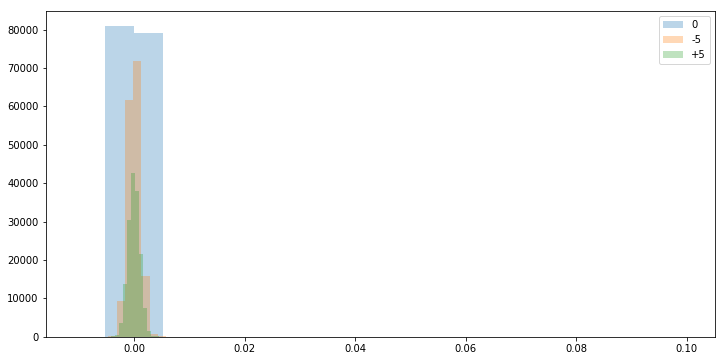

In [124]:
plt.figure(figsize=(12,6))
plt.hist(psf_2[:,:,depth].ravel(),bins=21, alpha=0.3, label='0')
plt.hist(psf_2[:,:,0].ravel(),bins=21, alpha=0.3, label='-5')
plt.hist(psf_2[:,:,-1].ravel(),bins=21, alpha=0.3, label='+5')
plt.legend()
plt.show()

In [126]:
%matplotlib notebook

<IPython.core.display.Javascript object>


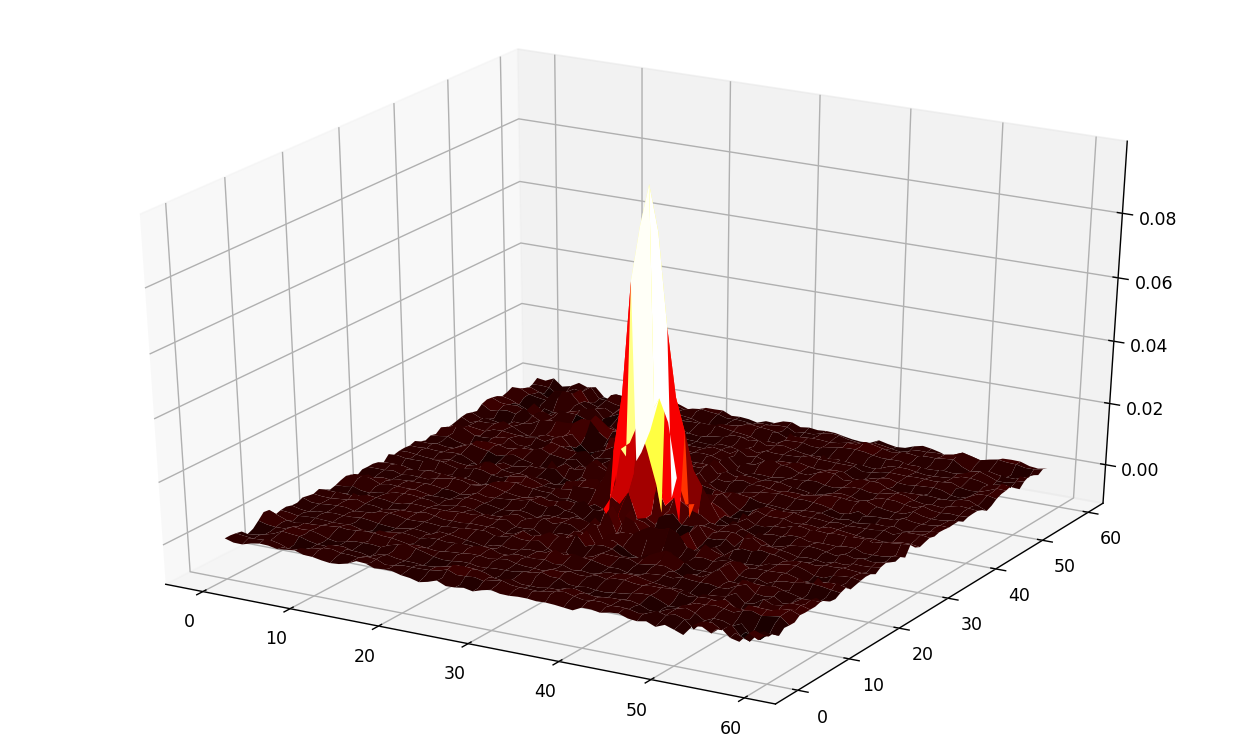

<IPython.core.display.Javascript object>


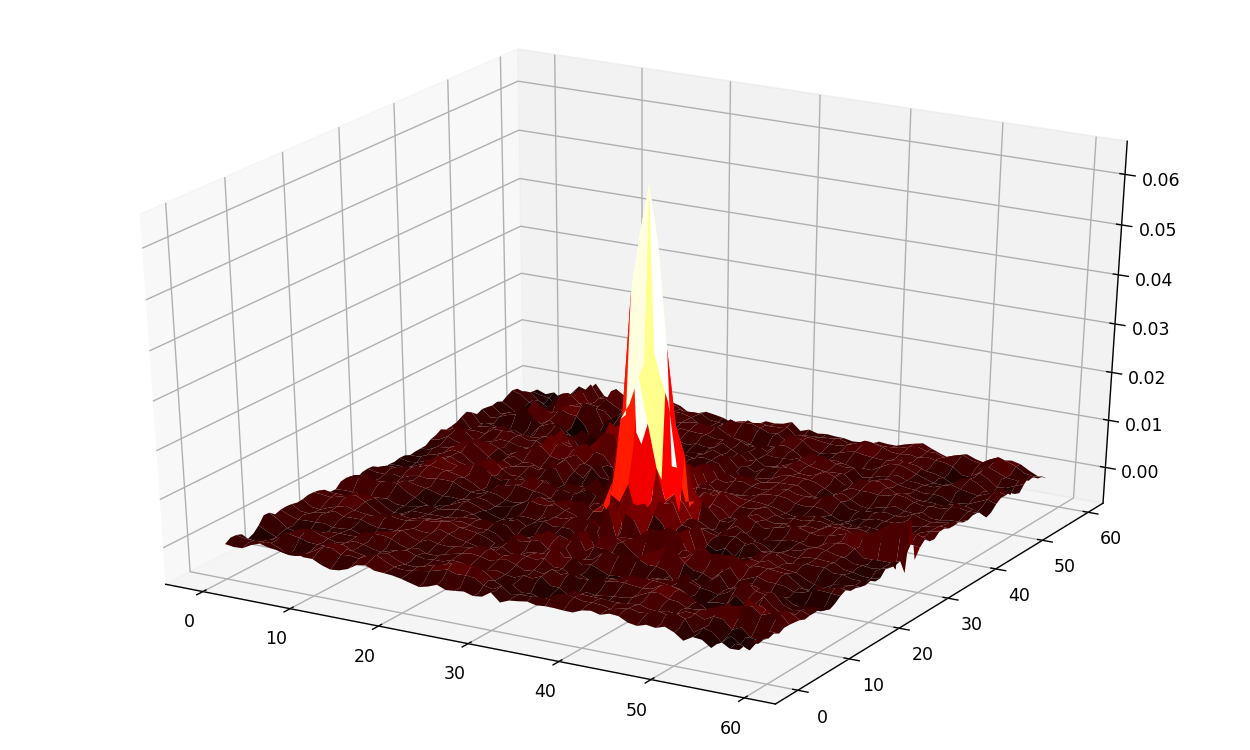

<IPython.core.display.Javascript object>


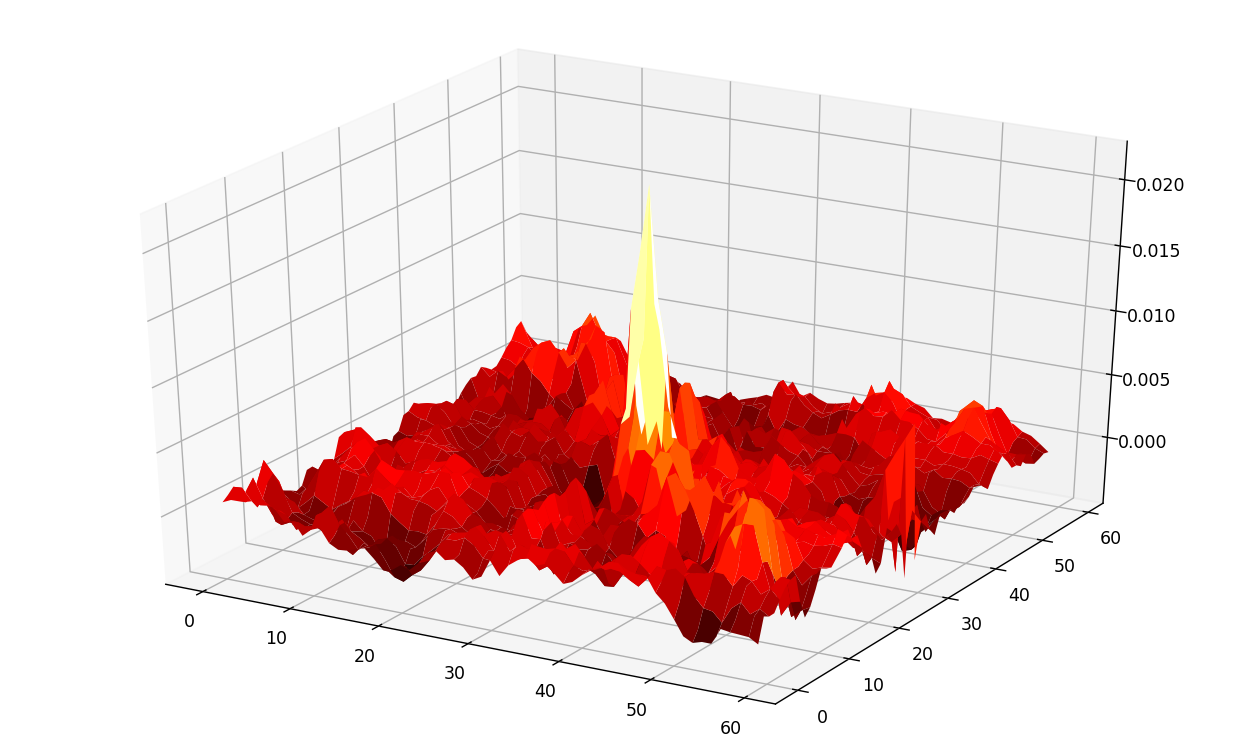

In [129]:
fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)

crop_size = 30
to_plot_1 = psf_2[:,:,depth]
to_plot_1 = to_plot_1[middle-crop:middle+crop, middle-crop:middle+crop]
X, Y = np.meshgrid(np.arange(0, to_plot.shape[0], 1), np.arange(0, to_plot.shape[1], 1))
ax.plot_surface(X, Y, to_plot_1, cmap='hot')
plt.show()

fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)
to_plot_2 = psf_2[:,:,depth-1]
to_plot_2 = to_plot_2[middle-crop:middle+crop, middle-crop:middle+crop]
ax.plot_surface(X, Y, to_plot_2, cmap='hot')
plt.show()

fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)
to_plot_2 = psf_2[:,:,0]
to_plot_2 = to_plot_2[middle-crop:middle+crop, middle-crop:middle+crop]
ax.plot_surface(X, Y, to_plot_2, cmap='hot')
plt.show()

In [134]:
t = './test_crop_part_17012020/'

middle = psf_2[:,:,depth].shape[0]//2
crop = 40
middle_max = np.max(psf_2[middle-crop:middle+crop, middle-crop:middle+crop,depth])

for i in range(2*depth+1):
    test_psf_3 = psf_2[middle-crop:middle+crop, middle-crop:middle+crop, i]
    test_psf_3 = test_psf_3/middle_max 
    
    test_psf_3 = test_psf_3 + np.abs(np.min(test_psf_3))
    #test_psf_3 = test_psf_3/np.max(test_psf_3)
    #print(test_psf_3.max(), test_psf_3.min(), np.median(test_psf_3))
    
    tiff.imsave( os.path.join(t, 'psf_attempt_1', 'C0000Z'+'{:04d}'.format(i)+'.tif'), np.float32(test_psf_3) )
print('Tout')

Tout


In [139]:
%matplotlib inline

49


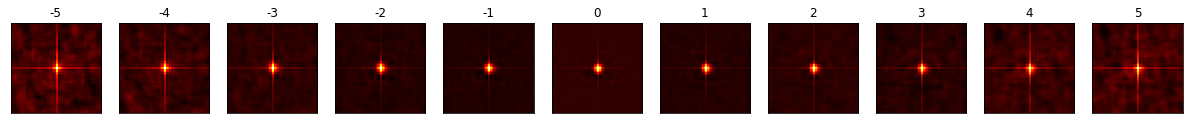

In [140]:
averaging_steps = 50
input_size = 100
depth = 5

average = np.zeros((input_size*4,input_size*4, 2*depth+1, averaging_steps))

for i in range(averaging_steps):
    if i%5==0:
        x_brain, y_brain, z_brain = np.random.randint(300,500), np.random.randint(150,550), np.random.randint(100,350)
        img_2 = brain.get_sample(  ((x_brain, x_brain+input_size),(y_brain, y_brain+input_size), (z_brain, z_brain+50)) )
    
    z = np.random.randint(depth, img_2.shape[2]-depth)
    psf_1, psf_2 = restore(img_2, z, depth, interp_esrgan)
    
    psf_2 = psf_2/np.max(psf_2)
    average[:,:,:,i] = psf_2
    
    current_average = np.mean(average, axis=3)
    middle = psf_2.shape[0]//2
    crop = 30
    
    clear_output()
    print(i)
    fig, axes = plt.subplots(nrows=1, ncols = current_average.shape[2])
    fig.set_figheight(8)
    fig.set_figwidth(21)
    for ax, psf_slice in zip(axes, range(current_average.shape[2])):
        ax.imshow( current_average[middle-crop:middle+crop, middle-crop:middle+crop, psf_slice], cmap='hot' )
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(str(psf_slice - current_average.shape[2]//2))
    plt.show()
    plt.pause(0.05)

In [141]:
t = './test_crop_part_17012020/'

current_average = np.mean(average, axis=3)

middle = current_average[:,:,depth].shape[0]//2
crop = 40
middle_max = np.max(current_average[middle-crop:middle+crop, middle-crop:middle+crop,depth])

for i in range(2*depth+1):
    test_psf_3 = current_average[middle-crop:middle+crop, middle-crop:middle+crop, i]
    test_psf_3 = test_psf_3/middle_max 
    
    test_psf_3 = test_psf_3 + np.abs(np.min(test_psf_3))
    #test_psf_3 = test_psf_3/np.max(test_psf_3)
    #print(test_psf_3.max(), test_psf_3.min(), np.median(test_psf_3))
    
    tiff.imsave( os.path.join(t, 'psf_attempt_multiple_50', 'C0000Z'+'{:04d}'.format(i)+'.tif'), np.float32(test_psf_3) )
print('Tout')

Tout


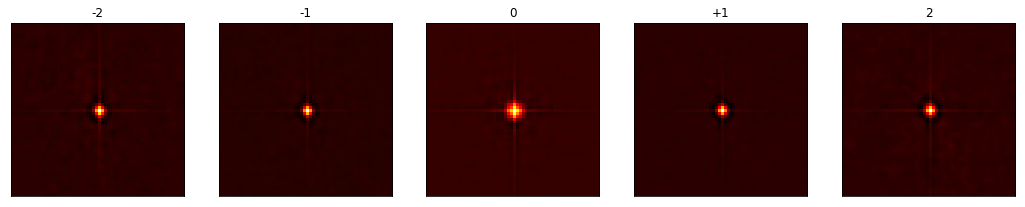

In [43]:
averaging_steps = 50
input_size = 100

average = np.zeros((input_size*4,input_size*4, 5, averaging_steps))

for i in range(averaging_steps):
    z = np.random.randint(2, img.shape[2]-2)
    
    slice_zuu = img[:,:,z-2]
    slice_zu = img[:,:,z-1]
    slice_zc = img[:,:,z]
    slice_zd = img[:,:,z+1]
    slice_zdd = img[:,:,z+2]
    """
    x = np.random.randint(0, slice_zc.shape[0]-input_size)
    y = np.random.randint(0, slice_zc.shape[1]-input_size)

    slice_zuu = slice_zuu[x:x+input_size, y:y+input_size]
    slice_zu = slice_zu[x:x+input_size, y:y+input_size]
    slice_zc = slice_zc[x:x+input_size, y:y+input_size]
    slice_zd = slice_zd[x:x+input_size, y:y+input_size]
    slice_zdd = slice_zdd[x:x+input_size, y:y+input_size]
    """
    test_slice = slice_zc
    slice_bicubic = cv2.resize(test_slice, (int(test_slice.shape[1]*4), int(test_slice.shape[0]*4)), cv2.INTER_CUBIC)

    slice_zuu = predict(interp_esrgan, slice_zuu)
    slice_zu = predict(interp_esrgan, slice_zu)
    slice_zc = predict(interp_esrgan, slice_zc)
    slice_zd = predict(interp_esrgan, slice_zd)
    slice_zdd = predict(interp_esrgan, slice_zdd)
    
    psf_c = extract_psf(slice_bicubic, slice_zc, normalize=False)
    psf_uu = extract_psf(slice_zuu, slice_zc, normalize=False)
    psf_u = extract_psf(slice_zu, slice_zc, normalize=False)
    psf_d = extract_psf(slice_zd, slice_zc, normalize=False)
    psf_dd = extract_psf(slice_zdd, slice_zc, normalize=False)
    """
    if i==0:
        average[:,:,0, i] = psf_uu
        average[:,:,1, i] = psf_u
        average[:,:,2, i] = psf_c
        average[:,:,3, i] = psf_d
        average[:,:,4, i] = psf_dd
    else:
        average[:,:,0] = np.mean( [psf_uu, average[:,:,0]], axis=0)
        average[:,:,1] = np.mean( [psf_u, average[:,:,1]], axis=0)
        average[:,:,2] = np.mean( [psf_c, average[:,:,2]], axis=0)
        average[:,:,3] = np.mean( [psf_d, average[:,:,3]], axis=0)
        average[:,:,4] = np.mean( [psf_dd, average[:,:,4]], axis=0)
    """
    average[:,:,0, i] = psf_uu
    average[:,:,1, i] = psf_u
    average[:,:,2, i] = psf_c
    average[:,:,3, i] = psf_d
    average[:,:,4, i] = psf_dd
    
    middle = average.shape[0]//2
    crop = 30
    current_average = np.mean(average, axis=3)
    
    clear_output()
    print(i)
    plt.figure(figsize=(18,6))
    plt.subplot(151, title='-2', xticks=(()), yticks=(()))
    plt.imshow( current_average[middle-crop:middle+crop, middle-crop:middle+crop, 0], cmap='hot')
    plt.subplot(152, title='-1', xticks=(()), yticks=(()))
    plt.imshow( current_average[middle-crop:middle+crop, middle-crop:middle+crop, 1], cmap='hot')
    plt.subplot(153, title='0', xticks=(()), yticks=(()))
    plt.imshow( current_average[middle-crop:middle+crop, middle-crop:middle+crop, 2], cmap='hot')
    plt.subplot(154, title='+1', xticks=(()), yticks=(()))
    plt.imshow( current_average[middle-crop:middle+crop, middle-crop:middle+crop, 3], cmap='hot')
    plt.subplot(155, title='2', xticks=(()), yticks=(()))
    plt.imshow( current_average[middle-crop:middle+crop, middle-crop:middle+crop, 4], cmap='hot')
    plt.show()
    plt.pause(0.05)

In [44]:
t = './test_crop_part_17012020/'

current_average = np.mean(average, axis=3)
middle = average.shape[0]//2
crop = 30

for i in range(5):
    test_psf_3 = current_average[middle-crop:middle+crop, middle-crop:middle+crop, i]
    
    test_psf_3 = test_psf_3 + np.abs(np.min(test_psf_3))
    test_psf_3 = test_psf_3/np.max(test_psf_3)
    #print(test_psf_3.max(), test_psf_3.min(), np.median(test_psf_3))
    
    tiff.imsave( os.path.join(t, 'psf_attempt_multiple', 'C0000Z'+'{:04d}'.format(i)+'.tif'), np.float32(test_psf_3) )

<hr>

## 3D-image construction

In [597]:
img= brain.get_sample(  ((500, 550),(500, 550), (100, 150)) )
brain.idx_projections(img, 48,30,10, transpose=True, resize=False)

x: (500, 550) y: (500, 550) z: (100, 150)


### Generated

In [712]:
generate = np.zeros((200,200,200), dtype=np.uint8)
tmp = np.zeros((200,200,50), dtype=np.uint8)

for i in range(0,50):
    test_slice = img[:,:,i]
    interp_predicted = predict(interp_esrgan, test_slice)
    tmp[:,:,i] = interp_predicted

for i_r in range(0,200):
    interp_predicted = tmp[:,i_r,:]
    interp_predicted= cv2.resize(interp_predicted, (200,200), cv2.INTER_CUBIC)
    generate[:,i_r,:] = interp_predicted
print('Z')

tmp = np.zeros((200,50,200), dtype=np.uint8)
for i in range(0,50):
    test_slice = img[:,i,:]
    interp_predicted = predict(interp_esrgan, test_slice)
    tmp[:,i,:] = interp_predicted

alpha = 0.2
for i_r in range(0,200):
    interp_predicted = tmp[i_r,:,:]
    interp_predicted= cv2.resize(interp_predicted, (200,200), cv2.INTER_CUBIC)
    generate[i_r,:,:] = (((interp_predicted.astype(float)/255)*alpha + (generate[i_r,:,:].astype(float)/255)*(1-alpha))*255).astype(np.uint8)

print('X')
tmp = np.zeros((50,200,200), dtype=np.uint8)
for i in range(0,50):
    test_slice = img[i,:,:]
    interp_predicted = predict(interp_esrgan, test_slice)
    tmp[i,:,:] = interp_predicted

alpha = 0.2
for i_r in range(0,200):
    interp_predicted = tmp[:,:,i_r]
    interp_predicted= cv2.resize(interp_predicted, (200,200), cv2.INTER_CUBIC)
    generate[:,:,i_r] = (((interp_predicted.astype(float)/255)*alpha + (generate[:,:,i_r].astype(float)/255)*(1-alpha))*255).astype(np.uint8)

print('Y')

Z
X
Y


In [715]:
brain.idx_projections(generate, 48*4,30*4,10*4-5, transpose=True, resize=False)

### Bicubic

In [717]:
bicubic = np.zeros((200,200,200), dtype=np.uint8)
tmp = np.zeros((200,200,50), dtype=np.uint8)

for i in range(0,50):
    test_slice = img[:,:,i]
    interp_predicted = cv2.resize(test_slice, (200,200), cv2.INTER_CUBIC)
    tmp[:,:,i] = interp_predicted

for i_r in range(0,200):
    interp_predicted = tmp[:,i_r,:]
    interp_predicted= cv2.resize(interp_predicted, (200,200), cv2.INTER_CUBIC)
    bicubic[:,i_r,:] = interp_predicted
print('Z')

tmp = np.zeros((200,50,200), dtype=np.uint8)
for i in range(0,50):
    test_slice = img[:,i,:]
    interp_predicted = cv2.resize(test_slice, (200,200), cv2.INTER_CUBIC)
    tmp[:,i,:] = interp_predicted

alpha = 0.2
for i_r in range(0,200):
    interp_predicted = tmp[i_r,:,:]
    interp_predicted= cv2.resize(interp_predicted, (200,200), cv2.INTER_CUBIC)
    bicubic[i_r,:,:] = (((interp_predicted.astype(float)/255)*alpha + (bicubic[i_r,:,:].astype(float)/255)*(1-alpha))*255).astype(np.uint8)

print('X')
tmp = np.zeros((50,200,200), dtype=np.uint8)
for i in range(0,50):
    test_slice = img[i,:,:]
    interp_predicted = cv2.resize(test_slice, (200,200), cv2.INTER_CUBIC)
    tmp[i,:,:] = interp_predicted

alpha = 0.2
for i_r in range(0,200):
    interp_predicted = tmp[:,:,i_r]
    interp_predicted= cv2.resize(interp_predicted, (200,200), cv2.INTER_CUBIC)
    bicubic[:,:,i_r] = (((interp_predicted.astype(float)/255)*alpha + (bicubic[:,:,i_r].astype(float)/255)*(1-alpha))*255).astype(np.uint8)

print('Y')

Z
X
Y


In [718]:
brain.idx_projections(bicubic, 48*4,30*4,10*4-5, transpose=True, resize=False)

Save

In [719]:
os.getcwd()

'/home/roman_kiryanov'

In [721]:
t = './test_crop_part_17012020/'
for i in range(200):
    cv2.imwrite(os.path.join(t,'bicubic', 'C0000Z'+'{:04d}'.format(i)+'.png'), bicubic[:,:,i])
    cv2.imwrite(os.path.join(t,'generated', 'C0001Z'+'{:04d}'.format(i)+'.png'), generate[:,:,i])
print('vse')

vse
